<a href="https://colab.research.google.com/github/Camicb/Copper-Forecasting/blob/main/2_Stock_Copper_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Stock copper Forecasting

The Chilean copper stock not only depend of the international situation but also the national productivity. The data provided by COCHILCO have 2 variables:

*   **Fecha** : Datetime
*   **Stock Cobre LME (Toneladas Metricas)**: the stock, in metric tonnes

I will perform the same methods that I used for the price copper forecasting: ARIMA based model and Facebook Prophet. Please refer to [here](https://github.com/Camicb/Copper-Forecasting/blob/main/1_Price_Copper_forecasting.ipynb)  to more details and explanations.

In [1]:
# Installing required libraries

!pip install pystan -q
!pip install fbprophet -q
!pip install statsmodels -q
!pip install pmdarima -q
!pip install scipy -q

     |████████████████████████████████| 1.5MB 8.1MB/s 
     |████████████████████████████████| 2.1MB 33.3MB/s 
     |████████████████████████████████| 9.5MB 31.9MB/s 


In [2]:
# Importing libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

In [3]:
# For reproducibility
np.random.seed(2021)

In [4]:
# Loading data
stock = pd.read_excel('/content/drive/MyDrive/DATASETS/Copper/stock_cobre.xlsx')

In [5]:
# Inspecting data
stock.tail()
print(' ')
stock.info()
print(' ')
stock.describe()

,Fecha,Stock Cobre LME (Toneladas Metricas)
5729,2021-03-11,90825
5730,2021-03-12,93450
5731,2021-03-15,92650
5732,2021-03-16,103900
5733,2021-03-17,107275


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5734 entries, 0 to 5733
Data columns (total 2 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Fecha                                  5734 non-null   datetime64[ns]
 1    Stock Cobre LME (Toneladas Metricas)  5734 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 89.7 KB
 


,Stock Cobre LME (Toneladas Metricas)
count,5734.00000
mean,352223.17684
std,232635.77586
min,25525.00000
25%,166481.25000
50%,293550.00000
75%,467762.50000
max,980075.00000


In [6]:
# Redefining variables for simplification purposes 
stock.columns = ['ds', 'y']
stock.drop(stock.index[0], inplace=True)
stock.head()

,ds,y
1,1999-01-05,594800
2,1999-01-06,599525
3,1999-01-07,600300
4,1999-01-08,601075
5,1999-01-11,602800


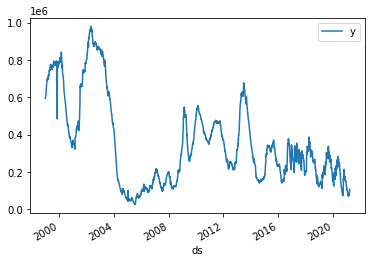

In [7]:
# Visualizing data
stock.plot(x='ds', y='y')

In [8]:
# Spliting data into training and testing datasets
train_size_stock = int(stock.shape[0]*0.9)
train_stock = stock[0:train_size_stock] # 90% data
test_stock = stock[train_size_stock:]  # 10% data

## 2.1 ARIMA based models

In [9]:
# Inspecting ARIMA models

train_stock.index = train_stock['ds']
test_stock.index =test_stock['ds']

model_stock = auto_arima(train_stock['y'], start_p=1, start_q=1,max_p=5, max_q=5, max_d=5, m=1, max_D=5, trace=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=106429.971, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=106522.562, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=106435.173, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=106441.979, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=106521.324, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=106353.396, Time=2.38 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=106423.444, Time=0.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=106346.242, Time=3.28 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=106399.172, Time=0.96 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=106346.193, Time=4.34 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=106381.597, Time=1.25 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=106347.370, Time=5.51 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=106333.729, Time=7.63 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=106334.741, Time=7.85 sec
 ARIM

In [10]:
# Model selection
model_stock.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5159
Model:               SARIMAX(2, 1, 1)   Log Likelihood              -53153.873
Date:                Sun, 28 Mar 2021   AIC                         106315.747
Time:                        23:50:57   BIC                         106341.940
Sample:                             0   HQIC                        106324.913
                               - 5159                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8415      0.010     80.531      0.000       0.821       0.862
ar.L2          0.1194      0.002     65.574      0.000       0.116       0.123
ma.L1         -0.9409      0.011    -89.531      0.000      -0.962      -0.920
sigma2      5.126e+07   2.54e-10   2.01e+17      0.000    5.13e+07    5.13e+07
===================================================================================
Ljung-Box (L1) (Q):                  81.87   Jarque-Bera (JB):         183270292.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -2.77
Prob(H) (two-sided):                  0.00   Kurtosis:                       926.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.34e+31. Standard errors may be unstable.
"""

In [11]:
# Making predictions
stock_predictions = pd.DataFrame(model_stock.predict(n_periods=len(test_stock)))
stock_predictions.index=test_stock.index
stock_predictions.columns = ['predictions']
stock_predictions

,predictions
ds,
2019-01-02,131797.001605
2019-01-03,131735.698295
2019-01-04,131638.964246
2019-01-07,131550.239531
2019-01-08,131464.023069
...,...
2021-03-11,129071.134853
2021-03-12,129071.134853
2021-03-15,129071.134853


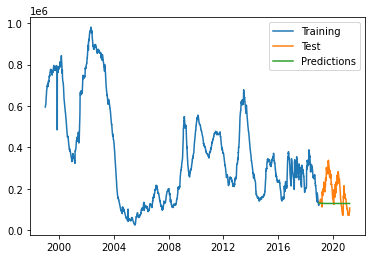

In [12]:
# Visualizing results
plt.plot(train_stock['y'], label='Training')
plt.plot(test_stock['y'], label='Test')
plt.plot(stock_predictions['predictions'], label='Predictions')
plt.legend()

In [13]:
# Metrics
mean_squared_error(test_stock['y'], stock_predictions['predictions'])

8001023250.456951

In the same way that with copper prices, the ARIMA based model was unable to predict correctly the values.

##2.2 Facebook Prophet

In [14]:
# Creating model
m_stock= Prophet(daily_seasonality=True)
m_stock.fit(train_stock)
future_stock = m_stock.make_future_dataframe(periods=807,freq='D') 
future_stock.tail()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,ds
5961,2021-03-13
5962,2021-03-14
5963,2021-03-15
5964,2021-03-16
5965,2021-03-17


In [15]:
# Making predictions
forecast_stock = m_stock.predict(future_stock)
forecast_stock[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5961,2021-03-13,220090.850601,-534284.797893,875752.033313
5962,2021-03-14,297505.017811,-452917.011473,961168.703307
5963,2021-03-15,311184.558562,-462651.627867,980590.233684
5964,2021-03-16,311304.045694,-439262.817762,951673.542977
5965,2021-03-17,311650.817546,-440270.150474,953998.523237


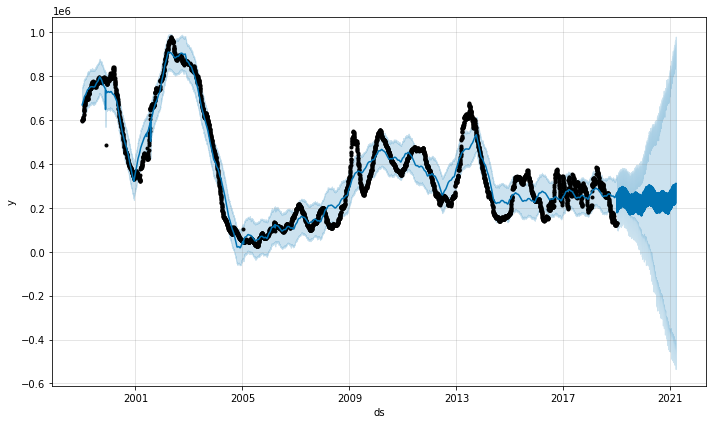

In [16]:
# Plot the forecast
fig1 = m_stock.plot(forecast_stock, uncertainty=True)

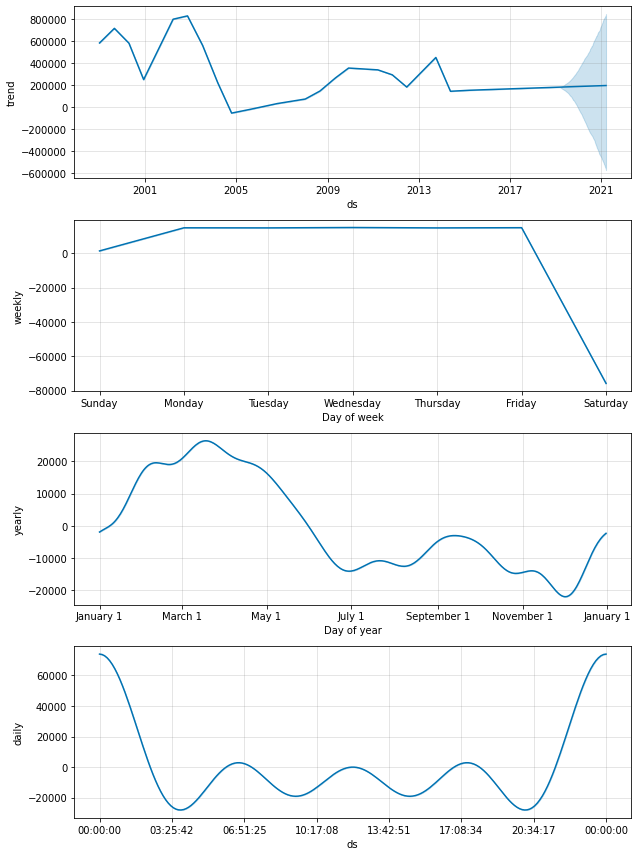

In [17]:
# Plot forecast components
fig2 = m_stock.plot_components(forecast_stock)

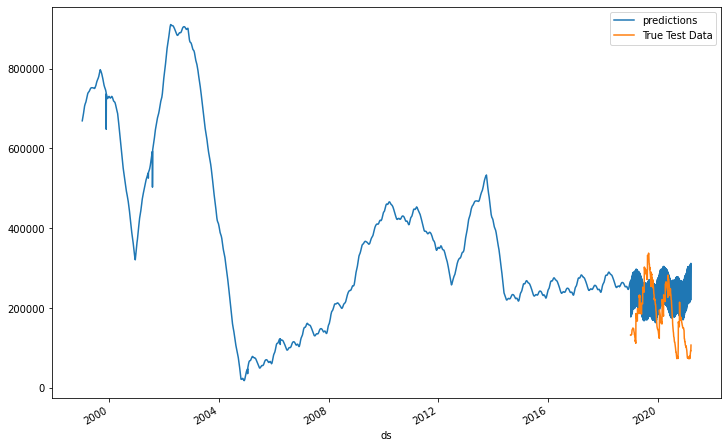

In [18]:
# Plot test data and predictions
ax_stock=forecast_stock.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test_stock.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax_stock)

In [19]:
# Metrics
y_test = test_stock['y']
y_predict = forecast_stock['yhat'][-(len(test_stock)):]
mean_squared_error(y_test, y_predict)

11722643559.78529

The results are even worse with Facebook Prophet than with the ARIMA model. This problem requires a more sophisticated method, like neural networks or collecting more data along with other variables.

### Conclusion

As the prices, stock of copper prices does not have a particular trend or seasonality. They highly depend on the national and international markets situation, and national productivity. Values of last year are very different to the past ones and therefore try to predict the future ones is hard.

#  Bibliography

*  https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

*  https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

*  https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html#pmdarima.arima.AutoARIMA

*  https://facebook.github.io/prophet/docs/quick_start.html#python-api

*  https://sailajakarra.medium.com/facebook-prophet-for-time-series-cf26be1be274
